In [1]:
setwd("/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.3_Cluster Distribution Analyses/Input")
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.3_Cluster Distribution Analyses/Output')
cur_date = "112720"

library("readxl")
library(factoextra)
library(missForest)
#library(plyr) #this must be loaded before tidyverse
library(tidyverse)
library(ggpubr)
library(janitor)
library(reshape2)
library(car) #package necessary to run anova and specify type III errors

#subject characteristics
subjectinfo <-  read.csv("SubjectInfo_102920.csv")

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: foreach

Loading required package: itertools

Loading required package: iterators

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate()    masks foreach::accumulate()
✖ dplyr::combine()       masks randomForest::combine()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::lag()           masks stats::lag()
✖ randomForest::margin() masks ggplot2::margin()
✖ purr

First obtaining the eigencytokines.

In [2]:
#### Recoding subject characteristic values  
subjectinfo$Sex <- ifelse(subjectinfo$Sex=="M", 1, 0) #coding Males as 1, Females as 0
subjectinfo$Ethnicity <- ifelse(subjectinfo$Ethnicity=="NH", 0, 1) #coding NH as 0, H as 1

#make categorical variables factors 
subjectinfo$Race <- factor(subjectinfo$Race, levels=c("W", "AA", "As", "O"))
subjectinfo$Group <- factor(subjectinfo$Group, levels=c("NS", "CS", "Ecig"))

In [3]:
#upload cytokine data for each compartment 
ELF_cyto <- read.csv("ELF_NonNorm_110220.csv")
NLF_cyto <- read.csv("NLF_NonNorm_110220.csv")
Serum_cyto <- read.csv("Serum_NonNorm_110220.csv")
Sputum_cyto <- read.csv("Sputum_NonNorm_110220.csv")

#transpose cytokine data for each compartment
ELF_cyto <- as.data.frame(t(ELF_cyto)) %>% 
  row_to_names(row_number = 1)
NLF_cyto <- as.data.frame(t(NLF_cyto)) %>% 
  row_to_names(row_number = 1)
Serum_cyto <- as.data.frame(t(Serum_cyto)) %>% 
  row_to_names(row_number = 1)
Sputum_cyto <- as.data.frame(t(Sputum_cyto)) %>% 
  row_to_names(row_number = 1)

#cluster assignments for each compartment 
ELF_clus <- read.csv("ELF_cluster_assignments.csv")
NLF_clus <- read.csv("NLF_cluster_assignments.csv")
Serum_clus <- read.csv("Serum_cluster_assignments.csv")
Sputum_clus <- read.csv("Sputum_cluster_assignments.csv")

#renaming first column, grouping and splitting by "Cluster" column
ELF_clus <- ELF_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
NLF_clus <- NLF_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
Serum_clus <- Serum_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
Sputum_clus <- Sputum_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split

#making dfs for each cluster for PCA analysis 
ELF_1 <- ELF_clus[[1]]
ELF_2 <- ELF_clus[[2]]
ELF_3 <- ELF_clus[[3]]

NLF_1 <- NLF_clus[[1]]
NLF_2 <- NLF_clus[[2]]
NLF_3 <- NLF_clus[[3]]

Serum_1 <- Serum_clus[[1]]
Serum_2 <- Serum_clus[[2]]
Serum_3 <- Serum_clus[[3]]

Sputum_1 <- Sputum_clus[[1]]
Sputum_2 <- Sputum_clus[[2]]
Sputum_3 <- Sputum_clus[[3]]

#making df with subjects' cytokine concentration data for each cluster 
ELF_1 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
ELF_2 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
ELF_3 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

NLF_1 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
NLF_2 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
NLF_3 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

Serum_1 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Serum_2 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Serum_3 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

Sputum_1 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Sputum_2 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Sputum_3 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

#PCA on each cluster, eigenvectors are in rotation -- PROBLEM - for some reason had to convert everything to numeric  
pca_ELF_1 <- ELF_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_ELF_2 <- ELF_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_ELF_3 <- ELF_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>%   
  prcomp()

pca_NLF_1 <- NLF_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_NLF_2 <- NLF_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_NLF_3 <- NLF_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

pca_Serum_1 <- Serum_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Serum_2 <- Serum_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Serum_3 <- Serum_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

pca_Sputum_1 <- Sputum_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Sputum_2 <- Sputum_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Sputum_3 <- Sputum_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

#eigenvector dfs of first principal component 
eigencytokines_ELF_1 <- data.frame(pca_ELF_1$rotation[,"PC1"])
  colnames(eigencytokines_ELF_1)[1] <- "Cluster1"
eigencytokines_ELF_2 <- data.frame(pca_ELF_2$rotation[,"PC1"])
  colnames(eigencytokines_ELF_2)[1] <- "Cluster2"
eigencytokines_ELF_3 <- data.frame(pca_ELF_3$rotation[,"PC1"])
  colnames(eigencytokines_ELF_3)[1] <- "Cluster3"

eigencytokines_NLF_1 <- data.frame(pca_NLF_1$rotation[,"PC1"])
  colnames(eigencytokines_NLF_1)[1] <- "Cluster1"
eigencytokines_NLF_2 <- data.frame(pca_NLF_2$rotation[,"PC1"])
  colnames(eigencytokines_NLF_2)[1] <- "Cluster2"
eigencytokines_NLF_3 <- data.frame(pca_NLF_3$rotation[,"PC1"])
  colnames(eigencytokines_NLF_3)[1] <- "Cluster3"
  
eigencytokines_Serum_1 <- data.frame(pca_Serum_1$rotation[,"PC1"])
  colnames(eigencytokines_Serum_1)[1] <- "Cluster1"
eigencytokines_Serum_2 <- data.frame(pca_Serum_2$rotation[,"PC1"])
  colnames(eigencytokines_Serum_2)[1] <- "Cluster2"
eigencytokines_Serum_3 <- data.frame(pca_Serum_3$rotation[,"PC1"])
  colnames(eigencytokines_Serum_3)[1] <- "Cluster3"

eigencytokines_Sputum_1 <- data.frame(pca_Sputum_1$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_1)[1] <- "Cluster1"
eigencytokines_Sputum_2 <- data.frame(pca_Sputum_2$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_2)[1] <- "Cluster2"
eigencytokines_Sputum_3 <- data.frame(pca_Sputum_3$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_3)[1] <- "Cluster3"
  

#collapse all eigencytokine dfs
eigencytokines_ELF <- cbind(eigencytokines_ELF_1, eigencytokines_ELF_2, eigencytokines_ELF_3)
eigencytokines_NLF <- cbind(eigencytokines_NLF_1, eigencytokines_NLF_2, eigencytokines_NLF_3)
eigencytokines_Serum <- cbind(eigencytokines_Serum_1, eigencytokines_Serum_2, eigencytokines_Serum_3)
eigencytokines_Sputum <- cbind(eigencytokines_Sputum_1, eigencytokines_Sputum_2, eigencytokines_Sputum_3)

Warning message in row_to_names(., row_number = 1):
“Row 1 does not provide unique names. Consider running clean_names() after row_to_names().”
Warning message:
“The `.data` argument of `add_column()` must have unique names as of tibble 3.0.0.
Use `.name_repair = "minimal"`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [4]:
#first pseudo log2 transforming all values and then scaling all eigencytokine dfs
eigencytokines_ELF_scaled <- as.data.frame(scale(log2(eigencytokines_ELF + 1)))
eigencytokines_NLF_scaled <- as.data.frame(scale(log2(eigencytokines_NLF + 1)))
eigencytokines_Serum_scaled <- as.data.frame(scale(log2(eigencytokines_Serum + 1)))
eigencytokines_Sputum_scaled <- as.data.frame(scale(log2(eigencytokines_Sputum + 1)))

In [5]:
head(eigencytokines_NLF_scaled)

,Cluster1,Cluster2,Cluster3
,<dbl>,<dbl>,<dbl>
CS_15,0.612519662,0.8639756,-0.2964233
CS_16,0.552006718,-1.2908904,0.2030666
CS_17,-0.305139341,-1.1524781,0.3838104
CS_18,-0.008338034,0.6456049,0.9183615
CS_19,1.222003189,-3.4347981,0.2108666
CS_20,-1.279548544,-0.1285845,0.3417576


In [6]:
#adding a col to designate smoking status 
eigen_NLF_scaled = eigencytokines_NLF_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster1, Cluster2, Cluster3, Group, Age)
eigen_ELF_scaled = eigencytokines_ELF_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster1, Cluster2, Cluster3, Group, Age)
eigen_Sputum_scaled = eigencytokines_Sputum_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster1, Cluster2, Cluster3, Group, Age)
eigen_Serum_scaled = eigencytokines_Serum_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster1, Cluster2, Cluster3, Group, Age)

Joining, by = "SubjectID"

Joining, by = "SubjectID"

Joining, by = "SubjectID"

Joining, by = "SubjectID"



In [7]:
head(eigen_NLF_scaled)

,SubjectID,Cluster1,Cluster2,Cluster3,Group,Age
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,CS_15,0.612519662,0.8639756,-0.2964233,CS,34
2,CS_16,0.552006718,-1.2908904,0.2030666,CS,33
3,CS_17,-0.305139341,-1.1524781,0.3838104,CS,24
4,CS_18,-0.008338034,0.6456049,0.9183615,CS,33
5,CS_19,1.222003189,-3.4347981,0.2108666,CS,29
6,CS_20,-1.279548544,-0.1285845,0.3417576,CS,25


# Checking Assumptions

Linearity Assumption

In [8]:
NLF_assumptions_df = eigen_NLF_scaled[,1:4] %>%
    pivot_longer(-SubjectID, names_to = 'Cluster', values_to = 'Conc') %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster, Conc, Group, Age) 
ELF_assumptions_df = eigen_ELF_scaled[,1:4] %>%
    pivot_longer(-SubjectID, names_to = 'Cluster', values_to = 'Conc') %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster, Conc, Group, Age) 
Sputum_assumptions_df = eigen_Sputum_scaled[,1:4] %>%
    pivot_longer(-SubjectID, names_to = 'Cluster', values_to = 'Conc') %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster, Conc, Group, Age) 
Serum_assumptions_df = eigen_Serum_scaled[,1:4] %>%
    pivot_longer(-SubjectID, names_to = 'Cluster', values_to = 'Conc') %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster, Conc, Group, Age) 

Joining, by = "SubjectID"

Joining, by = "SubjectID"

Joining, by = "SubjectID"

Joining, by = "SubjectID"



In [9]:
add_compartment = function(dataframe, compartment_name){
    #"""
    #Takes the dataframes already made from above and adds a column specifying the compartment.

    #:param: compartment dataframe and compartment name
    #:output: a 22x3 matrix containing mean, sd, and compartment for each cytokine. 
    #"""
    Compartment = rep(compartment_name, times = length(dataframe$Cluster))
    combined_df = cbind(dataframe,Compartment)
    return(combined_df)
}
NLF_assumptions_df = add_compartment(NLF_assumptions_df,'NLF')
ELF_assumptions_df = add_compartment(ELF_assumptions_df, 'ELF')
Sputum_assumptions_df = add_compartment(Sputum_assumptions_df, 'Sputum')
Serum_assumptions_df = add_compartment(Serum_assumptions_df, 'Serum')

#combining into a single df
assumptions_df = rbind(NLF_assumptions_df, ELF_assumptions_df, Sputum_assumptions_df, Serum_assumptions_df)
head(assumptions_df)

,SubjectID,Cluster,Conc,Group,Age,Compartment
,<chr>,<chr>,<dbl>,<fct>,<int>,<chr>
1,CS_15,Cluster1,0.6125197,CS,34,NLF
2,CS_15,Cluster2,0.8639756,CS,34,NLF
3,CS_15,Cluster3,-0.2964233,CS,34,NLF
4,CS_16,Cluster1,0.5520067,CS,33,NLF
5,CS_16,Cluster2,-1.2908904,CS,33,NLF
6,CS_16,Cluster3,0.2030666,CS,33,NLF


`geom_smooth()` using formula 'y ~ x'



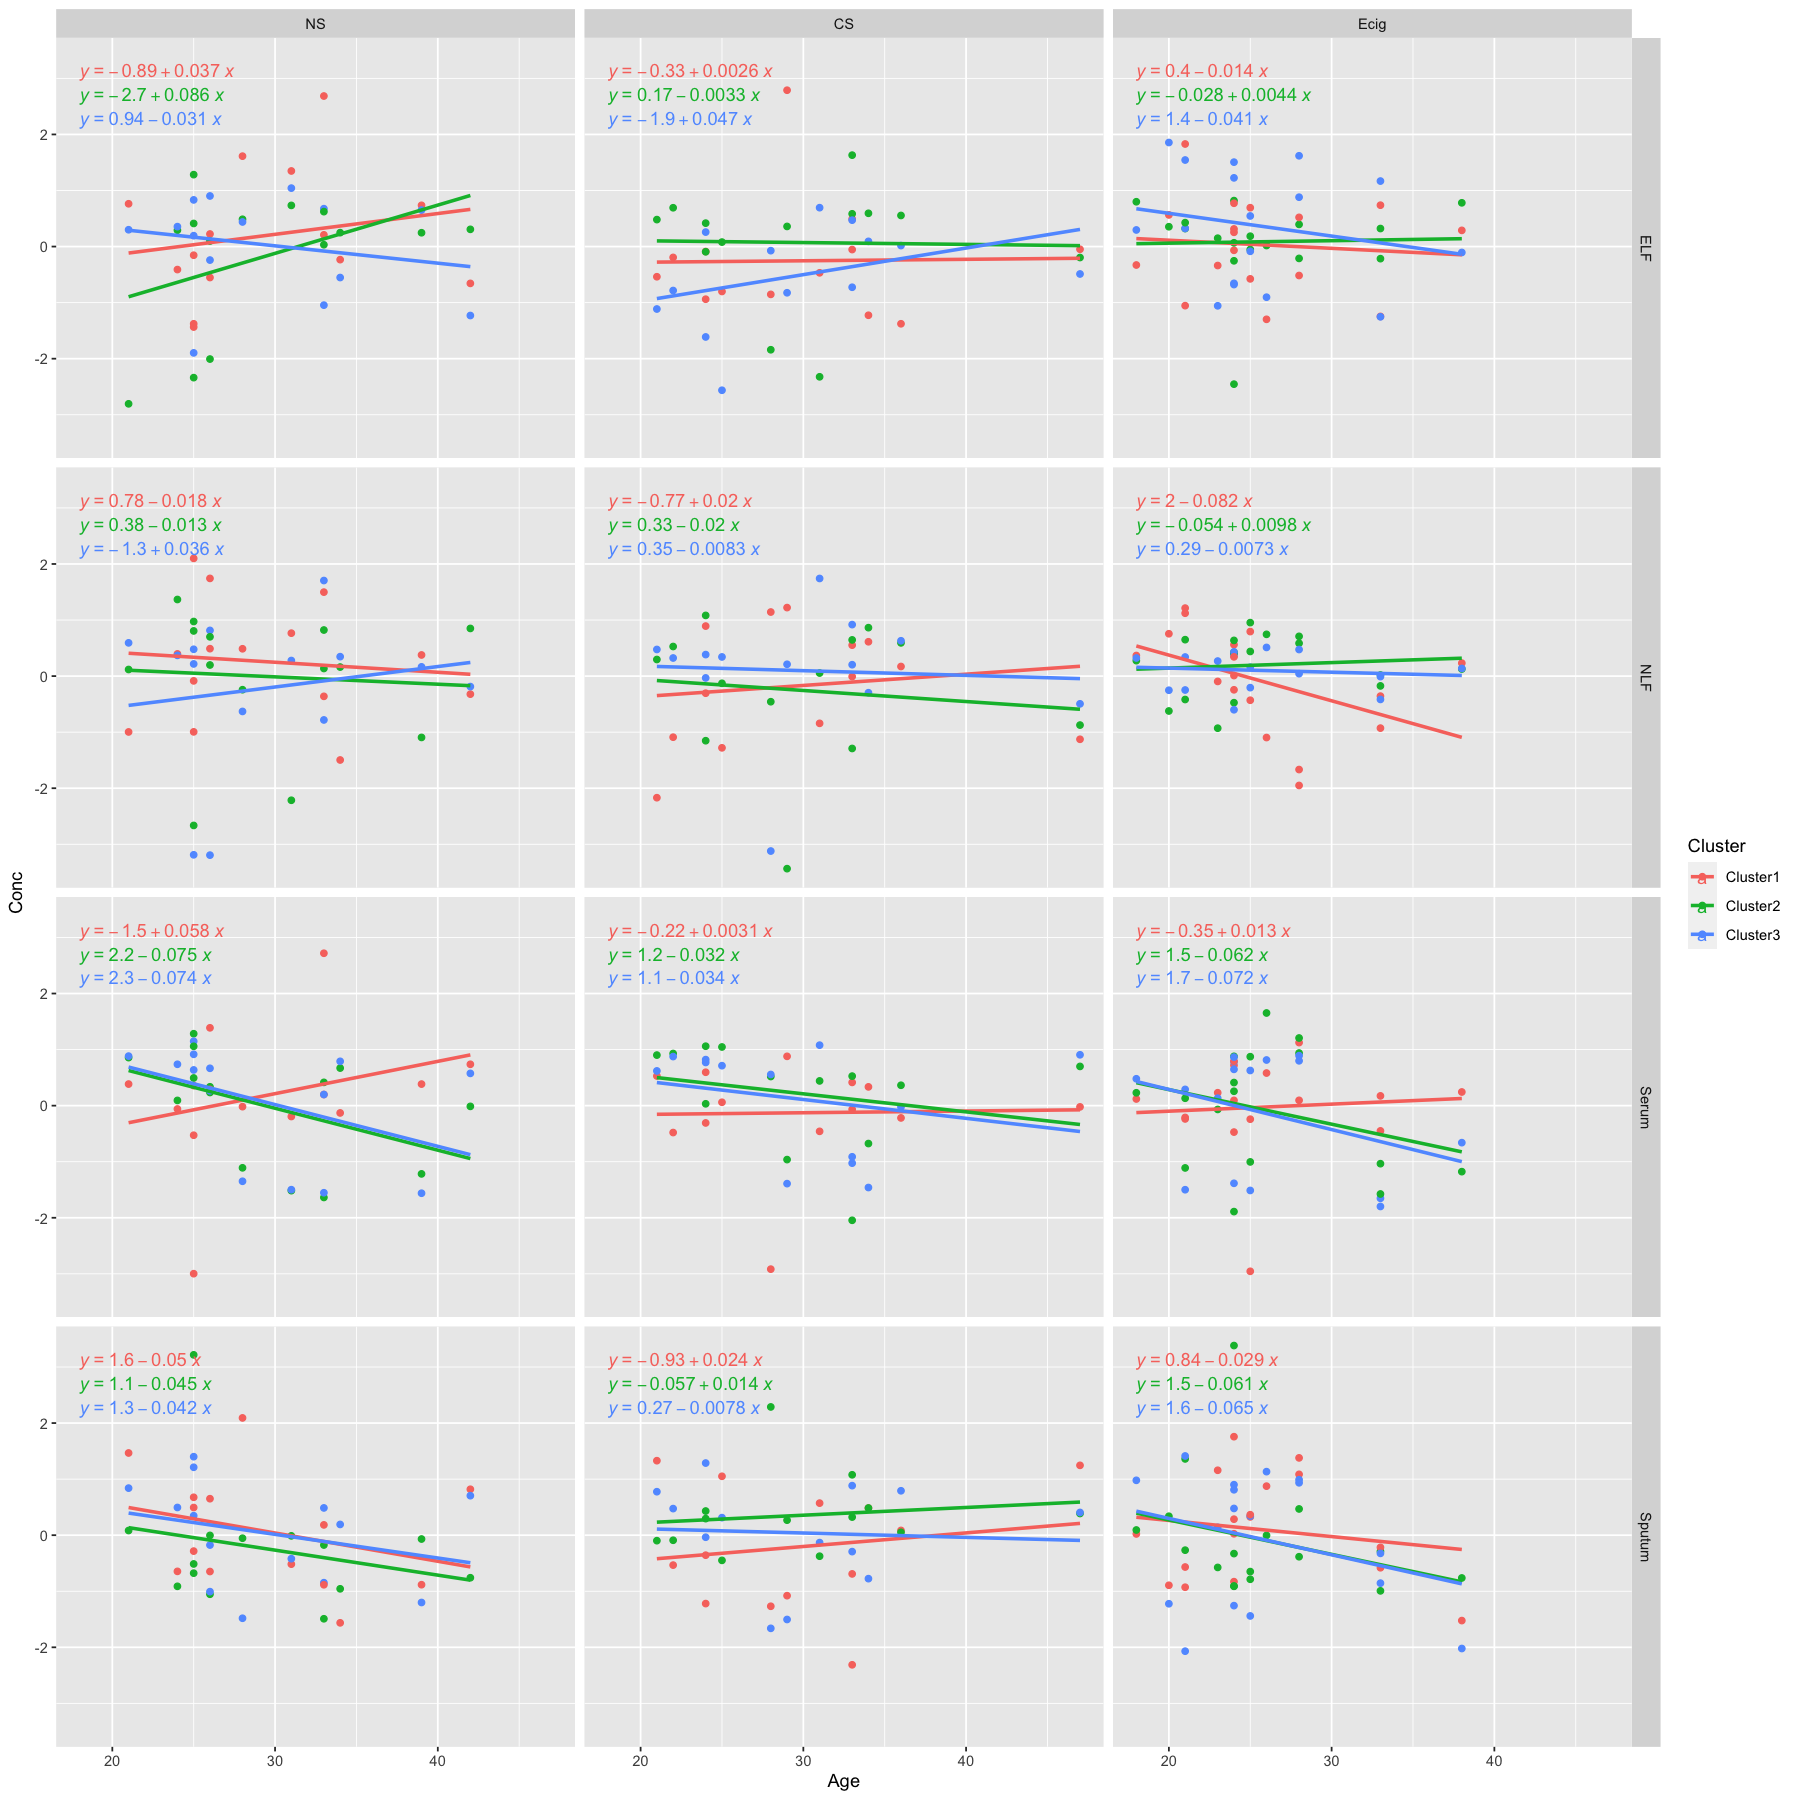

In [10]:
#this is for ancova first
#scatter plot b/w covariate(age) & outcome variable (clustered cytokine concentration)
options(repr.plot.width=15, repr.plot.height=15) #changing size
ggplot(data = assumptions_df, aes(x = Age, y = Conc, color = Cluster, group = Cluster)) + 
  geom_point() + 
  geom_smooth(method = 'lm', se = FALSE) + 
  #geom_text(aes(x = Age, y = Conc, label = summary(lm(Conc ~ Age, assumptions_df))$r.squared), parse = TRUE) + 
  stat_regline_equation() + 
  facet_grid(Compartment~Group)

In [11]:
#need r squared values for these
lm_eqn <- function(df,cluster, group){
    m <- lm(Conc ~ Age, df %>%
           filter(Cluster == cluster, Group == group));
    eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(r)^2~"="~r2, 
         list(a = format(unname(coef(m)[1]), digits = 2),
              b = format(unname(coef(m)[2]), digits = 2),
             r2 = format(summary(m)$r.squared, digits = 3)))
    as.character(as.expression(eq));
}
#ancova
lm_eqn(NLF_assumptions_df, 'Cluster1', 'NS')
lm_eqn(NLF_assumptions_df, 'Cluster1', 'CS')
lm_eqn(NLF_assumptions_df, 'Cluster1', 'Ecig')
lm_eqn(NLF_assumptions_df, 'Cluster2', 'NS')
lm_eqn(NLF_assumptions_df, 'Cluster2', 'CS')
lm_eqn(NLF_assumptions_df, 'Cluster2', 'Ecig')
lm_eqn(NLF_assumptions_df, 'Cluster3', 'NS')
lm_eqn(NLF_assumptions_df, 'Cluster3', 'CS')
lm_eqn(NLF_assumptions_df, 'Cluster3', 'Ecig')
lm_eqn(ELF_assumptions_df, 'Cluster1', 'NS')
lm_eqn(ELF_assumptions_df, 'Cluster1', 'CS')
lm_eqn(ELF_assumptions_df, 'Cluster1', 'Ecig')
lm_eqn(ELF_assumptions_df, 'Cluster2', 'NS')
lm_eqn(ELF_assumptions_df, 'Cluster2', 'CS')
lm_eqn(ELF_assumptions_df, 'Cluster2', 'Ecig')
lm_eqn(ELF_assumptions_df, 'Cluster3', 'NS')
lm_eqn(ELF_assumptions_df, 'Cluster3', 'CS')
lm_eqn(ELF_assumptions_df, 'Cluster3', 'Ecig')
lm_eqn(Sputum_assumptions_df, 'Cluster1', 'NS')
lm_eqn(Sputum_assumptions_df, 'Cluster1', 'CS')
lm_eqn(Sputum_assumptions_df, 'Cluster1', 'Ecig')
lm_eqn(Sputum_assumptions_df, 'Cluster2', 'NS')
lm_eqn(Sputum_assumptions_df, 'Cluster2', 'CS')
lm_eqn(Sputum_assumptions_df, 'Cluster2', 'Ecig')
lm_eqn(Sputum_assumptions_df, 'Cluster3', 'NS')
lm_eqn(Sputum_assumptions_df, 'Cluster3', 'CS')
lm_eqn(Sputum_assumptions_df, 'Cluster3', 'Ecig')
lm_eqn(Serum_assumptions_df, 'Cluster1', 'NS')
lm_eqn(Serum_assumptions_df, 'Cluster1', 'CS')
lm_eqn(Serum_assumptions_df, 'Cluster1', 'Ecig')
lm_eqn(Serum_assumptions_df, 'Cluster2', 'NS')
lm_eqn(Serum_assumptions_df, 'Cluster2', 'CS')
lm_eqn(Serum_assumptions_df, 'Cluster2', 'Ecig')
lm_eqn(Serum_assumptions_df, 'Cluster3', 'NS')
lm_eqn(Serum_assumptions_df, 'Cluster3', 'CS')
lm_eqn(Serum_assumptions_df, 'Cluster3', 'Ecig')

[1] "italic(y) == \"0.78\" + \"-0.018\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0106\""

[1] "italic(y) == \"-0.77\" + \"0.02\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0181\""

[1] "italic(y) == \"2\" + \"-0.082\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.209\""

[1] "italic(y) == \"0.38\" + \"-0.013\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.00444\""

[1] "italic(y) == \"0.33\" + \"-0.02\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0131\""

[1] "italic(y) == \"-0.054\" + \"0.0098\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.00853\""

[1] "italic(y) == \"-1.3\" + \"0.036\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0254\""

[1] "italic(y) == \"0.35\" + \"-0.0083\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.00283\""

[1] "italic(y) == \"0.29\" + \"-0.0073\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0123\""

[1] "italic(y) == \"-0.89\" + \"0.037\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0386\""

[1] "italic(y) == \"-0.33\" + \"0.0026\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.000311\""

[1] "italic(y) == \"0.4\" + \"-0.014\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0081\""

[1] "italic(y) == \"-2.7\" + \"0.086\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.177\""

[1] "italic(y) == \"0.17\" + \"-0.0033\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.000478\""

[1] "italic(y) == \"-0.028\" + \"0.0044\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.000952\""

[1] "italic(y) == \"0.94\" + \"-0.031\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0441\""

[1] "italic(y) == \"-1.9\" + \"0.047\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.139\""

[1] "italic(y) == \"1.4\" + \"-0.041\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0412\""

[1] "italic(y) == \"1.6\" + \"-0.05\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0913\""

[1] "italic(y) == \"-0.93\" + \"0.024\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0239\""

[1] "italic(y) == \"0.84\" + \"-0.029\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0255\""

[1] "italic(y) == \"1.1\" + \"-0.045\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0602\""

[1] "italic(y) == \"-0.057\" + \"0.014\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0193\""

[1] "italic(y) == \"1.5\" + \"-0.061\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.086\""

[1] "italic(y) == \"1.3\" + \"-0.042\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0795\""

[1] "italic(y) == \"0.27\" + \"-0.0078\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0037\""

[1] "italic(y) == \"1.6\" + \"-0.065\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0803\""

[1] "italic(y) == \"-1.5\" + \"0.058\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0833\""

[1] "italic(y) == \"-0.22\" + \"0.0031\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.000538\""

[1] "italic(y) == \"-0.35\" + \"0.013\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.00506\""

[1] "italic(y) == \"2.2\" + \"-0.075\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.221\""

[1] "italic(y) == \"1.2\" + \"-0.032\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0615\""

[1] "italic(y) == \"1.5\" + \"-0.062\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0847\""

[1] "italic(y) == \"2.3\" + \"-0.074\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.188\""

[1] "italic(y) == \"1.1\" + \"-0.034\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.0622\""

[1] "italic(y) == \"1.7\" + \"-0.072\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.116\""

The r squared values indicate that the linearity assumption isn't met. 

<b> Homogeneity of Regression Slopes: checks that there's no significant interaction between the covariate and the grouping variable. </b>

In [12]:
library(rstatix)


Attaching package: ‘rstatix’


The following object is masked from ‘package:janitor’:

    make_clean_names


The following object is masked from ‘package:stats’:

    filter




In [13]:
homogeneity_test_ancova = function(df, cluster){
    test = df %>%
        filter(Cluster == cluster) %>%
        anova_test(Conc~Group*Age)
    return(test[3,]) #just need the last row that shows this interaction
}
homogeneity_test_ancova(NLF_assumptions_df, 'Cluster1')
homogeneity_test_ancova(NLF_assumptions_df, 'Cluster2')
homogeneity_test_ancova(NLF_assumptions_df, 'Cluster3')
homogeneity_test_ancova(ELF_assumptions_df, 'Cluster1')
homogeneity_test_ancova(ELF_assumptions_df, 'Cluster2')
homogeneity_test_ancova(ELF_assumptions_df, 'Cluster3')
homogeneity_test_ancova(Sputum_assumptions_df, 'Cluster1')
homogeneity_test_ancova(Sputum_assumptions_df, 'Cluster2')
homogeneity_test_ancova(Sputum_assumptions_df, 'Cluster3')
homogeneity_test_ancova(Serum_assumptions_df, 'Cluster1')
homogeneity_test_ancova(Serum_assumptions_df, 'Cluster2')
homogeneity_test_ancova(Serum_assumptions_df, 'Cluster3')

Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,1.279,0.29,,0.063


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.105,0.9,,0.006


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.298,0.744,,0.015


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.298,0.744,,0.015


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,1.203,0.312,,0.06


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,1.376,0.265,,0.068


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.765,0.472,,0.039


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.832,0.443,,0.042


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.403,0.671,,0.021


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,37,0.395,0.677,,0.021


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,37,0.274,0.762,,0.015


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,37,0.28,0.757,,0.015


Since none of the pvalues < 0.05, this assumption is met. 

<b>Normality of residuals</b>

In [14]:
#this is for ancova
residual_normality_test = function(df, cluster){
    model = lm(Conc~Age+Group, data = df %>%
        filter(Cluster == cluster))
    model.metrics <- augment(model) 
    shapiro_wilk_test = shapiro_test(model.metrics$.resid)
    return(shapiro_wilk_test)
}
residual_normality_test(NLF_assumptions_df, 'Cluster1')
residual_normality_test(NLF_assumptions_df, 'Cluster2') #residuals aren't normal
residual_normality_test(NLF_assumptions_df, 'Cluster3') #residuals aren't normal
residual_normality_test(ELF_assumptions_df, 'Cluster1') #residuals aren't normal
residual_normality_test(ELF_assumptions_df, 'Cluster2') #residuals aren't normal
residual_normality_test(ELF_assumptions_df, 'Cluster3')
residual_normality_test(Sputum_assumptions_df, 'Cluster1')
residual_normality_test(Sputum_assumptions_df, 'Cluster2') #residuals aren't normal
residual_normality_test(Sputum_assumptions_df, 'Cluster3') #residuals aren't normal
residual_normality_test(Serum_assumptions_df, 'Cluster1') #residuals aren't normal
residual_normality_test(Serum_assumptions_df, 'Cluster2')
residual_normality_test(Serum_assumptions_df, 'Cluster3') #residuals aren't normal

variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9763147,0.4933768


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.8814153,0.0003064762


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.7955045,2.334409e-06


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9437617,0.03238538


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.8281264,1.269401e-05


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9541105,0.07832629


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.975952,0.4805519


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.7756034,8.954073e-07


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9288056,0.009489398


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.8211883,1.061983e-05


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9688984,0.2895841


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.8966122,0.0009890024


This assumption isn't met for most clusters. 

<b> Homogeneity of Variances: ANCOVA/ ANOVA assumes the variance of residuals is equal for all groups </b>

In [15]:
residual_variance_test_anova = function(df, cluster){
    model = lm(Conc~Group, data = df %>%
        filter(Cluster == cluster))
    model.metrics <- augment(model) 
    levene_test = model.metrics %>%
        levene_test(.resid~Group)
    return(levene_test)
}
#anova
residual_variance_test_anova(NLF_assumptions_df, 'Cluster1')
residual_variance_test_anova(NLF_assumptions_df, 'Cluster2') 
residual_variance_test_anova(NLF_assumptions_df, 'Cluster3') 
residual_variance_test_anova(ELF_assumptions_df, 'Cluster1') 
residual_variance_test_anova(ELF_assumptions_df, 'Cluster2') 
residual_variance_test_anova(ELF_assumptions_df, 'Cluster3')
residual_variance_test_anova(Sputum_assumptions_df, 'Cluster1')
residual_variance_test_anova(Sputum_assumptions_df, 'Cluster2') 
residual_variance_test_anova(Sputum_assumptions_df, 'Cluster3') 
residual_variance_test_anova(Serum_assumptions_df, 'Cluster1') 
residual_variance_test_anova(Serum_assumptions_df, 'Cluster2')
residual_variance_test_anova(Serum_assumptions_df, 'Cluster3') 

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.2857891,0.7529056


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,1.733188,0.1894168


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,1.96277,0.1534462


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.5171135,0.6000759


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.6466438,0.5290594


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.5758263,0.5667214


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.3311726,0.7199842


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.3560151,0.702606


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.8823342,0.4215259


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,40,0.2200798,0.8034199


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,40,0.5776645,0.56582


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,40,0.1323426,0.8764228


In [16]:
residual_variance_test_ancova = function(df, cluster){
    model = lm(Conc~Age+Group, data = df %>%
        filter(Cluster == cluster))
    model.metrics <- augment(model) 
    levene_test = model.metrics %>%
        levene_test(.resid~Group)
    return(levene_test)
}
#ancova
residual_variance_test_ancova(NLF_assumptions_df, 'Cluster1')
residual_variance_test_ancova(NLF_assumptions_df, 'Cluster2') 
residual_variance_test_ancova(NLF_assumptions_df, 'Cluster3') 
residual_variance_test_ancova(ELF_assumptions_df, 'Cluster1') 
residual_variance_test_ancova(ELF_assumptions_df, 'Cluster2') 
residual_variance_test_ancova(ELF_assumptions_df, 'Cluster3')
residual_variance_test_ancova(Sputum_assumptions_df, 'Cluster1')
residual_variance_test_ancova(Sputum_assumptions_df, 'Cluster2') 
residual_variance_test_ancova(Sputum_assumptions_df, 'Cluster3') 
residual_variance_test_ancova(Serum_assumptions_df, 'Cluster1') 
residual_variance_test_ancova(Serum_assumptions_df, 'Cluster2')
residual_variance_test_ancova(Serum_assumptions_df, 'Cluster3') 

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.5349044,0.5897569


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,1.696957,0.1958567


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,1.965003,0.1531339


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.5246141,0.5957026


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.773067,0.468206


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.5634001,0.5736148


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.4657391,0.6309508


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.1155568,0.8911591


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,41,0.6713058,0.5165679


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,40,0.155904,0.8561587


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,40,0.4796294,0.6225268


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,40,0.1748066,0.8402574


None of these were significant (p < 0.05) so this assumption is met.

# One-way ANOVA

In [9]:
#now I can run the anova comparing each group to one another within each cluster
#contrasts show what compartments are being compared in anova
#these comparisons aren't what we want so I changed them in the function below
contrasts(eigen_NLF_scaled$Group)

,CS,Ecig
NS,0,0
CS,1,0
Ecig,0,1


                 Table of Contrasts
>                   NS    | CS  |  Ecig  |  Sum
>     Contrast 1 |  -1    |  1  |   0    |   0
>     Contrast 2 |  -1    |  0  |   1    |   0

> - Contrast 1: compares NS to CS
> - Contrast 2: compares NS to Ecig

In [17]:
get_anova1 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is specified above
    anova = aov(Cluster1~Group, data = scaled_df)
    return(anova)
}
get_anova2 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is specified above
    anova = aov(Cluster2~Group, data = scaled_df)
    return(anova)
}

get_anova3 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is specified above
    anova = aov(Cluster3~Group, data = scaled_df)
    return(anova)
}


#calling fn
NLF_Cluster1_anova = get_anova1(eigen_NLF_scaled)
NLF_Cluster2_anova = get_anova2(eigen_NLF_scaled)
NLF_Cluster3_anova = get_anova3(eigen_NLF_scaled)
ELF_Cluster1_anova = get_anova1(eigen_ELF_scaled)
ELF_Cluster2_anova = get_anova2(eigen_ELF_scaled)
ELF_Cluster3_anova = get_anova3(eigen_ELF_scaled)
Sputum_Cluster1_anova = get_anova1(eigen_Sputum_scaled)
Sputum_Cluster2_anova = get_anova2(eigen_Sputum_scaled)
Sputum_Cluster3_anova = get_anova3(eigen_Sputum_scaled)
Serum_Cluster1_anova = get_anova1(eigen_Serum_scaled)
Serum_Cluster2_anova = get_anova2(eigen_Serum_scaled)
Serum_Cluster3_anova = get_anova3(eigen_Serum_scaled)

In [18]:
#viewing results
summary(NLF_Cluster1_anova)
summary(NLF_Cluster2_anova)
summary(NLF_Cluster3_anova)
summary(ELF_Cluster1_anova)
summary(ELF_Cluster2_anova)
summary(ELF_Cluster3_anova) #this was the only that was even close to being significant
summary(Sputum_Cluster1_anova)
summary(Sputum_Cluster2_anova)
summary(Sputum_Cluster3_anova)
summary(Serum_Cluster1_anova)
summary(Serum_Cluster2_anova)
summary(Serum_Cluster3_anova)

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

          Length Class  Mode     
statistic 1      -none- numeric  
parameter 1      -none- numeric  
p.value   1      -none- numeric  
method    1      -none- character
data.name 1      -none- character

In [12]:
#need this for glht fn
library(multcomp)

Loading required package: mvtnorm

Warning message:
“package ‘mvtnorm’ was built under R version 4.0.3”
Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser




In [ ]:
# Tukey's post hoc
# NLF_Cluster1_tukey_anova = TukeyHSD(NLF_Cluster1_anova, type = 'III')
# NLF_Cluster2_tukey_anova = TukeyHSD(NLF_Cluster2_anova, type = 'III')
# NLF_Cluster3_tukey_anova = TukeyHSD(NLF_Cluster3_anova, type = 'III')
# ELF_Cluster1_tukey_anova = TukeyHSD(ELF_Cluster1_anova, type = 'III')
# ELF_Cluster2_tukey_anova = TukeyHSD(ELF_Cluster2_anova, type = 'III')
# ELF_Cluster3_tukey_anova = TukeyHSD(ELF_Cluster3_anova, type = 'III')
# Sputum_Cluster1_tukey_anova = TukeyHSD(Sputum_Cluster1_anova, type = 'III')
# Sputum_Cluster2_tukey_anova = TukeyHSD(Sputum_Cluster2_anova, type = 'III')
# Sputum_Cluster3_tukey_anova = TukeyHSD(Sputum_Cluster3_anova, type = 'III')
# Serum_Cluster1_tukey_anova = TukeyHSD(Serum_Cluster1_anova, type = 'III')
# Serum_Cluster2_tukey_anova = TukeyHSD(Serum_Cluster2_anova, type = 'III')
# Serum_Cluster3_tukey_anova = TukeyHSD(Serum_Cluster3_anova, type = 'III')

# ANCOVA

In [13]:
#controlling for age
get_ancova_age1 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1))#meaning is explained above
    ancova = aov(Cluster1~Age+Group, data = scaled_df)
    return(ancova)
}
get_ancova_age2 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is explained above
    ancova = aov(Cluster2~Age+Group, data = scaled_df)
    return(ancova)
}
get_ancova_age3 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is explained above
    ancova = aov(Cluster3~Age+Group, data = scaled_df)
    return(ancova)
}

#calling fn
NLF_Cluster1_ancova_age = get_ancova_age1(eigen_NLF_scaled)
NLF_Cluster2_ancova_age = get_ancova_age2(eigen_NLF_scaled)
NLF_Cluster3_ancova_age = get_ancova_age3(eigen_NLF_scaled)
ELF_Cluster1_ancova_age = get_ancova_age1(eigen_ELF_scaled)
ELF_Cluster2_ancova_age = get_ancova_age2(eigen_ELF_scaled)
ELF_Cluster3_ancova_age = get_ancova_age3(eigen_ELF_scaled)
Sputum_Cluster1_ancova_age = get_ancova_age1(eigen_Sputum_scaled)
Sputum_Cluster2_ancova_age = get_ancova_age2(eigen_Sputum_scaled)
Sputum_Cluster3_ancova_age = get_ancova_age3(eigen_Sputum_scaled)
Serum_Cluster1_ancova_age = get_ancova_age1(eigen_Serum_scaled)
Serum_Cluster2_ancova_age = get_ancova_age2(eigen_Serum_scaled)
Serum_Cluster3_ancova_age = get_ancova_age3(eigen_Serum_scaled)

In [14]:
#viewing results
summary(NLF_Cluster1_ancova_age)
summary(NLF_Cluster2_ancova_age)
summary(NLF_Cluster3_ancova_age)
summary(ELF_Cluster1_ancova_age)
summary(ELF_Cluster2_ancova_age)
summary(ELF_Cluster3_ancova_age)
summary(Sputum_Cluster1_ancova_age)
summary(Sputum_Cluster2_ancova_age)
summary(Sputum_Cluster3_ancova_age)
summary(Serum_Cluster1_ancova_age)
summary(Serum_Cluster2_ancova_age)
summary(Serum_Cluster3_ancova_age)

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.42  0.4173   0.408  0.527
Group        2   1.64  0.8183   0.799  0.457
Residuals   40  40.95  1.0237               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.47  0.4708   0.455  0.504
Group        2   1.15  0.5749   0.556  0.578
Residuals   40  41.38  1.0345               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.01  0.0064   0.006  0.938
Group        2   1.00  0.5024   0.479  0.623
Residuals   40  41.99  1.0497               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.06  0.0612   0.059  0.809
Group        2   1.46  0.7292   0.703  0.501
Residuals   40  41.48  1.0370               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.78  0.7816   0.758  0.389
Group        2   0.95  0.4772   0.463  0.633
Residuals   40  41.26  1.0316               

            Df Sum Sq Mean Sq F value Pr(>F)  
Age          1   0.52  0.5203   0.558  0.459  
Group        2   5.19  2.5932   2.781  0.074 .
Residuals   40  37.29  0.9323                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.52  0.5173   0.494  0.486
Group        2   0.60  0.3005   0.287  0.752
Residuals   40  41.88  1.0470               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.65  0.6465   0.655  0.423
Group        2   2.89  1.4466   1.466  0.243
Residuals   40  39.46  0.9865               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   1.39  1.3875   1.352  0.252
Group        2   0.55  0.2755   0.268  0.766
Residuals   40  41.06  1.0265               

            Df Sum Sq Mean Sq F value Pr(>F)
Age          1   0.80  0.8025   0.758  0.389
Group        2   0.68  0.3402   0.321  0.727
Residuals   39  41.27  1.0583               

            Df Sum Sq Mean Sq F value Pr(>F)  
Age          1   3.26   3.257   3.557 0.0667 .
Group        2   1.71   0.856   0.934 0.4014  
Residuals   39  35.71   0.916                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)  
Age          1   3.57   3.569   3.699 0.0618 .
Group        2   1.76   0.879   0.911 0.4105  
Residuals   39  37.63   0.965                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
# Tukey's post hoc 
# NLF_Cluster1_tukey_ancova = summary(glht(NLF_Cluster1_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none")) 
# NLF_Cluster2_tukey_ancova = summary(glht(NLF_Cluster2_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none"))
# NLF_Cluster3_tukey_ancova = summary(glht(NLF_Cluster3_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none"))
# ELF_Cluster1_tukey_ancova = summary(glht(ELF_Cluster1_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none")) 
# ELF_Cluster2_tukey_ancova = summary(glht(ELF_Cluster2_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none"))
# ELF_Cluster3_tukey_ancova = summary(glht(ELF_Cluster3_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none"))
# Sputum_Cluster1_tukey_ancova = summary(glht(Sputum_Cluster1_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none")) 
# Sputum_Cluster2_tukey_ancova = summary(glht(Sputum_Cluster2_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none"))
# Sputum_Cluster3_tukey_ancova = summary(glht(Sputum_Cluster3_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none"))
# Serum_Cluster1_tukey_ancova = summary(glht(Serum_Cluster1_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none")) 
# Serum_Cluster2_tukey_ancova = summary(glht(Serum_Cluster2_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none"))
# Serum_Cluster3_tukey_ancova = summary(glht(Serum_Cluster3_ancova_age, linfct=mcp(Group = "Tukey")), test = adjusted("none"))

# ANOVA/ANCOVA Tables

In [15]:
extract_values = function(anova_results){
    #extracting f and p values from the anova to be put into a table
    cluster_summary = summary(anova_results)[[1]][1, 2:5] #f value, pvalue
    f_value = cluster_summary$`F value`
    p_value = cluster_summary$`Pr(>F)`
    
    cluster_anova_values = c(f_value,p_value)
    return(cluster_anova_values)
}

#anova
NLF_Cluster1_anova_values = extract_values(NLF_Cluster1_anova)
NLF_Cluster2_anova_values = extract_values(NLF_Cluster2_anova)
NLF_Cluster3_anova_values = extract_values(NLF_Cluster3_anova)
ELF_Cluster1_anova_values = extract_values(ELF_Cluster1_anova)
ELF_Cluster2_anova_values = extract_values(ELF_Cluster2_anova)
ELF_Cluster3_anova_values = extract_values(ELF_Cluster3_anova)
Sputum_Cluster1_anova_values = extract_values(Sputum_Cluster1_anova)
Sputum_Cluster2_anova_values = extract_values(Sputum_Cluster2_anova)
Sputum_Cluster3_anova_values = extract_values(Sputum_Cluster3_anova)
Serum_Cluster1_anova_values = extract_values(Serum_Cluster1_anova)
Serum_Cluster2_anova_values = extract_values(Serum_Cluster2_anova)
Serum_Cluster3_anova_values = extract_values(Serum_Cluster3_anova)

#ancova
NLF_Cluster1_ancova_age_values = extract_values(NLF_Cluster1_ancova_age)
NLF_Cluster2_ancova_age_values = extract_values(NLF_Cluster2_ancova_age)
NLF_Cluster3_ancova_age_values = extract_values(NLF_Cluster3_ancova_age)
ELF_Cluster1_ancova_age_values = extract_values(ELF_Cluster1_ancova_age)
ELF_Cluster2_ancova_age_values = extract_values(ELF_Cluster2_ancova_age)
ELF_Cluster3_ancova_age_values = extract_values(ELF_Cluster3_ancova_age)
Sputum_Cluster1_ancova_age_values = extract_values(Sputum_Cluster1_ancova_age)
Sputum_Cluster2_ancova_age_values = extract_values(Sputum_Cluster2_ancova_age)
Sputum_Cluster3_ancova_age_values = extract_values(Sputum_Cluster3_ancova_age)
Serum_Cluster1_ancova_age_values = extract_values(Serum_Cluster1_ancova_age)
Serum_Cluster2_ancova_age_values = extract_values(Serum_Cluster2_ancova_age)
Serum_Cluster3_ancova_age_values = extract_values(Serum_Cluster3_ancova_age)

In [16]:
table_summary = function(NLF_Cluster1, NLF_Cluster2, NLF_Cluster3, ELF_Cluster1, ELF_Cluster2, 
                         ELF_Cluster3, Sputum_Cluster1, Sputum_Cluster2, Sputum_Cluster3, Serum_Cluster1, 
                         Serum_Cluster2, Serum_Cluster3){
    #comment
    table_initial = rbind(NLF_Cluster1, NLF_Cluster2, NLF_Cluster3, ELF_Cluster1, ELF_Cluster2, 
                         ELF_Cluster3, Sputum_Cluster1, Sputum_Cluster2, Sputum_Cluster3, Serum_Cluster1, 
                         Serum_Cluster2, Serum_Cluster3)
    
    colnames(table_initial) = c('F Value','p value')
    return(table_initial)
}

#calling function
anova_table = table_summary(NLF_Cluster1_anova_values, NLF_Cluster2_anova_values, NLF_Cluster3_anova_values, 
                            ELF_Cluster1_anova_values, ELF_Cluster2_anova_values, ELF_Cluster3_anova_values, 
                            Sputum_Cluster1_anova_values, Sputum_Cluster2_anova_values, Sputum_Cluster3_anova_values, 
                            Serum_Cluster1_anova_values, Serum_Cluster2_anova_values, Serum_Cluster3_anova_values)
ancova_age_table = table_summary(NLF_Cluster1_ancova_age_values, NLF_Cluster2_ancova_age_values, 
                                 NLF_Cluster3_ancova_age_values, ELF_Cluster1_ancova_age_values, 
                                 ELF_Cluster2_ancova_age_values, ELF_Cluster3_ancova_age_values, 
                                 Sputum_Cluster1_ancova_age_values, Sputum_Cluster2_ancova_age_values, 
                                 Sputum_Cluster3_ancova_age_values, Serum_Cluster1_ancova_age_values, 
                                 Serum_Cluster2_ancova_age_values, Serum_Cluster3_ancova_age_values)
allresults = cbind(anova_table, ancova_age_table)

,F Value,p value,F Value,p value
NLF_Cluster1,0.69953008,0.50265077,0.407689756,0.52678360
NLF_Cluster2,0.73518531,0.48562946,0.455150695,0.50378000
NLF_Cluster3,0.46402711,0.63200795,0.006049892,0.93839001
ELF_Cluster1,0.69057907,0.50702135,0.059003220,0.80931970
ELF_Cluster2,0.28929582,0.75030646,0.757627064,0.38926598
ELF_Cluster3,3.13213402,0.05421805,0.558051274,0.45941533
Sputum_Cluster1,0.38933059,0.67998828,0.494097197,0.48617647
Sputum_Cluster2,1.27839383,0.28935053,0.655320352,0.42300646
Sputum_Cluster3,0.05274737,0.94868390,1.351607705,0.25188668
Serum_Cluster1,0.31978372,0.72814571,0.758304179,0.38918858


In [17]:
col_names = c('F Value ANOVA','p value', 'P Adj', 'F Value ANCOVA','p value', 'P Adj')
final_table_summary = function(table, names_vector){
    #going back to calculate padj values
    padj = apply(cbind(table[,2],table[,4]), 2, p.adjust, method = "fdr") #the 2 applies function down the col
    
    #inserting these back into the OG df to export all values
    final_table = cbind(table[,1], table[,2], padj[,1], table[,3], table[,4],padj[,2])
    colnames(final_table) = names_vector
    return(final_table)
}
#calling fn
clustered_anova_ancova = final_table_summary(allresults, col_names)
clustered_anova_ancova

,F Value ANOVA,p value,P Adj,F Value ANCOVA,p value,P Adj
NLF_Cluster1,0.69953008,0.50265077,0.8522913,0.407689756,0.52678360,0.6321403
NLF_Cluster2,0.73518531,0.48562946,0.8522913,0.455150695,0.50378000,0.6321403
NLF_Cluster3,0.46402711,0.63200795,0.8522913,0.006049892,0.93839001,0.9383900
ELF_Cluster1,0.69057907,0.50702135,0.8522913,0.059003220,0.80931970,0.8828942
ELF_Cluster2,0.28929582,0.75030646,0.8522913,0.757627064,0.38926598,0.6321403
ELF_Cluster3,3.13213402,0.05421805,0.6506166,0.558051274,0.45941533,0.6321403
Sputum_Cluster1,0.38933059,0.67998828,0.8522913,0.494097197,0.48617647,0.6321403
Sputum_Cluster2,1.27839383,0.28935053,0.8522913,0.655320352,0.42300646,0.6321403
Sputum_Cluster3,0.05274737,0.94868390,0.9486839,1.351607705,0.25188668,0.6321403
Serum_Cluster1,0.31978372,0.72814571,0.8522913,0.758304179,0.38918858,0.6321403


In [18]:
#exporting data
write.csv(clustered_anova_ancova, paste0(Output,"/", cur_date, "_Clustered_ANOVA_ANCOVA.csv"), row.names= TRUE)

# Tukey's HSD Tables

In [ ]:
tukey_table_mean_diff = function(NLF_Cluster1, NLF_Cluster2, NLF_Cluster3, ELF_Cluster1, ELF_Cluster2, 
                         ELF_Cluster3, Sputum_Cluster1, Sputum_Cluster2, Sputum_Cluster3, Serum_Cluster1, 
                         Serum_Cluster2, Serum_Cluster3){
    #comment
    table_initial = rbind(t(NLF_Cluster1[[1]])[1,],t(NLF_Cluster2[[1]])[1,],t(NLF_Cluster3[[1]])[1,], #get mean diff
                          t(ELF_Cluster1[[1]])[1,],t(ELF_Cluster2[[1]])[1,],t(ELF_Cluster3[[1]])[1,],
                          t(Sputum_Cluster1[[1]])[1,],t(Sputum_Cluster2[[1]])[1,],t(Sputum_Cluster3[[1]])[1,],
                          t(Serum_Cluster1[[1]])[1,],t(Serum_Cluster2[[1]])[1,],t(Serum_Cluster3[[1]])[1,])
    return(table_initial)   
}

#calling function
tukey_anova_mean_diff = tukey_table_mean_diff(NLF_Cluster1_tukey_anova, NLF_Cluster2_tukey_anova, 
                                              NLF_Cluster3_tukey_anova, ELF_Cluster1_tukey_anova, 
                                              ELF_Cluster2_tukey_anova, ELF_Cluster3_tukey_anova, 
                                              Sputum_Cluster1_tukey_anova, Sputum_Cluster2_tukey_anova, 
                                              Sputum_Cluster3_tukey_anova, Serum_Cluster1_tukey_anova, 
                                              Serum_Cluster2_tukey_anova, Serum_Cluster3_tukey_anova)
tukey_ancova_mean_diff = tukey_table_mean_diff(NLF_Cluster1_tukey_ancova, NLF_Cluster2_tukey_ancova, 
                                              NLF_Cluster3_tukey_ancova, ELF_Cluster1_tukey_ancova, 
                                              ELF_Cluster2_tukey_ancova, ELF_Cluster3_tukey_ancova, 
                                              Sputum_Cluster1_tukey_ancova, Sputum_Cluster2_tukey_ancova, 
                                              Sputum_Cluster3_tukey_ancova, Serum_Cluster1_tukey_ancova, 
                                              Serum_Cluster2_tukey_ancova, Serum_Cluster3_tukey_ancova)

In [ ]:
tukey_table_pvalue = function(NLF_Cluster1, NLF_Cluster2, NLF_Cluster3, ELF_Cluster1, ELF_Cluster2, 
                         ELF_Cluster3, Sputum_Cluster1, Sputum_Cluster2, Sputum_Cluster3, Serum_Cluster1, 
                         Serum_Cluster2, Serum_Cluster3){
    #comment
    table_initial = rbind(t(NLF_Cluster1[[1]])[4,],t(NLF_Cluster2[[1]])[4,],t(NLF_Cluster3[[1]])[4,],  #get p value
                          t(ELF_Cluster1[[1]])[4,],t(ELF_Cluster2[[1]])[4,],t(ELF_Cluster3[[1]])[4,],
                          t(Sputum_Cluster1[[1]])[4,],t(Sputum_Cluster2[[1]])[4,],t(Sputum_Cluster3[[1]])[4,],
                          t(Serum_Cluster1[[1]])[4,],t(Serum_Cluster2[[1]])[4,],t(Serum_Cluster3[[1]])[4,])
    return(table_initial)   
}

#calling function
tukey_anova_pvalue = tukey_table_pvalue(NLF_Cluster1_tukey_anova, NLF_Cluster2_tukey_anova, 
                                              NLF_Cluster3_tukey_anova, ELF_Cluster1_tukey_anova, 
                                              ELF_Cluster2_tukey_anova, ELF_Cluster3_tukey_anova, 
                                              Sputum_Cluster1_tukey_anova, Sputum_Cluster2_tukey_anova, 
                                              Sputum_Cluster3_tukey_anova, Serum_Cluster1_tukey_anova, 
                                              Serum_Cluster2_tukey_anova, Serum_Cluster3_tukey_anova)

In [ ]:
#going back to calculate padj values
clustered_tukey_pvalues = cbind(tukey_anova_pvalue, tukey_ancova_age_pvalue)
padj_tukey = apply(allresults2, 2, p.adjust, method = "fdr")

#making one matrix
tukey_results = cbind(tukey_anova_mean_diff[,1], tukey_anova_pvalue[,1], padj_tukey[,1], tukey_anova_mean_diff[,2],
                      tukey_anova_pvalue[,2], padj_tukey[,2])
colnames(tukey_results) = c('Mean Diff (NS vs. CS)', 'P Value', 'P Adj', 'Mean Diff (NS vs. Ecig)', 'P Value', 
                            'P Adj', 'ANCOVA Mean Diff (NS vs. CS)', 'P Value', 'P Adj', 
                            'ANCOVA Mean Diff (NS vs. Ecig)', 'P Value', 'P Adj')

In [ ]:
#exporting data
write.csv(clustered_anova_ancova, paste0(Output,"/", cur_date, "_Clustered_ANOVA_ANCOVA.csv"), row.names= TRUE)